# Time Series Normalization

Normalizing a time series in relation to a set of other time series involves constructing a statistical model that connects the inputs and outputs, incorporating an additional numeric feature to represent time. This time feature accounts for the variations in the analyzed time series that cannot be explained by the input features, thus isolating the behavior of the analyzed time series from the influence of those input features.

## 1. How is time processed as a feature?

The time index is converted into a numeric feature in a straightforward manner: assigning 0 to the first timestamp and incrementing by 1 at a frequency defined by the user.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
original_freq = 'h'
time_index = pd.date_range(start='2024-01-01', freq=original_freq, periods=30*24)
time_index

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 01:00:00',
               '2024-01-01 02:00:00', '2024-01-01 03:00:00',
               '2024-01-01 04:00:00', '2024-01-01 05:00:00',
               '2024-01-01 06:00:00', '2024-01-01 07:00:00',
               '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               ...
               '2024-01-30 14:00:00', '2024-01-30 15:00:00',
               '2024-01-30 16:00:00', '2024-01-30 17:00:00',
               '2024-01-30 18:00:00', '2024-01-30 19:00:00',
               '2024-01-30 20:00:00', '2024-01-30 21:00:00',
               '2024-01-30 22:00:00', '2024-01-30 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='h')

An hourly time index processed to a daily `freq_trend`:

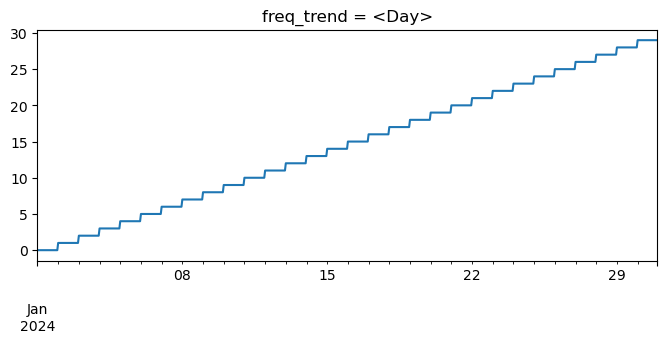

In [3]:
freq_trend = 'd'

freq_trend = pd.tseries.frequencies.to_offset(freq_trend)
time_numeric = (time_index - time_index.min()).floor(freq_trend) / freq_trend
time_numeric = pd.Series(time_numeric, index=time_index, name='time_numeric')

time_numeric.plot(figsize=(8, 3), title=f'freq_trend = {freq_trend}')
plt.show()

An hourly time index processed to a more customed `freq_trend`:

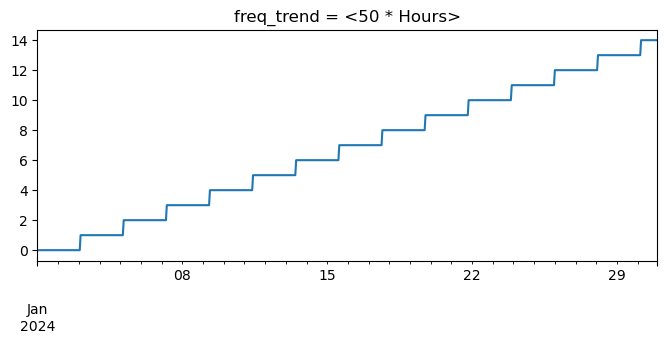

In [4]:
freq_trend = '50h'

freq_trend = pd.tseries.frequencies.to_offset(freq_trend)
time_numeric = (time_index - time_index.min()).floor(freq_trend) / freq_trend
time_numeric = pd.Series(time_numeric, index=time_index, name='time_numeric')

time_numeric.plot(figsize=(8, 3), title=f'freq_trend = {freq_trend}')
plt.show()

What does this entail? By adding the numeric time feature to the dataset, gradient boosting methods (or any tree-based methods) can partition the time dimension at any given node. For instance, if `time_numeric` is less than *x*, the model proceeds to the left child; otherwise, it goes to the right child. This allows the model to make different decisions based on time. Consequently, the statistical model can compute time-localized shifts to better capture variations in the output that cannot be explained by the other features.

To prevent overfitting, it is recommended to set the `freq_trend` to a value higher than the frequency of the original dataset.

## 2. Toy Dataset

Let’s generate a toy dataset:
- `a`: a time series
- `b`: a time series that is a function of `a`, with added noise, and then shifted by +0.4 during a specific time span
- `dummy`: a noise-only variable

When plotted, the shift is barely noticeable to the naked eye.

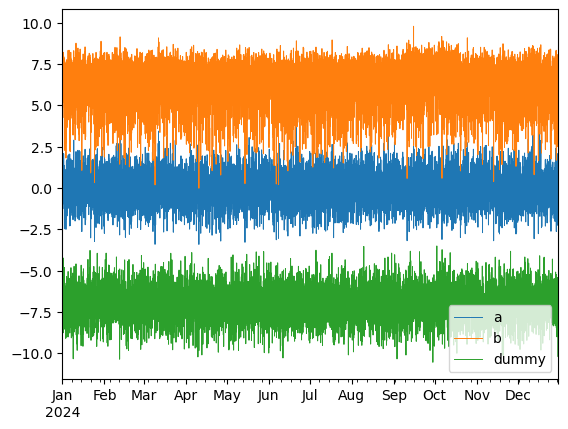

In [13]:
import numpy as np
from apyxl import XGBRegressorWrapper

n = 8760
time = pd.date_range(start='2024-01-01', freq='h', periods=n)


def f(x):
    return np.where(x >= 0, 0.5*x, 2*x)


a = np.random.randn(n)
b = 7 + f(a) + 0.3*np.random.randn(n)

df = np.c_[a, b]

# Shift time serie `b` on a continuous subset of the period
df[6000:7000, 1] += 0.4

df = pd.DataFrame(df, columns=['a', 'b'], index=time)
df['dummy'] = np.random.randn(n) - 7

df.plot(lw=0.7)
plt.show()

Let's construct `time_numeric` according to the process described earlier, with `freq_trend` set to one day:

C:\Users\cjoly\miniforge3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\cjoly\miniforge3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


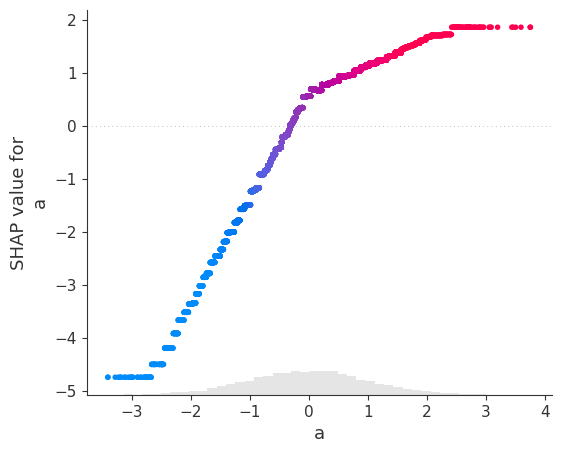

C:\Users\cjoly\miniforge3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\cjoly\miniforge3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


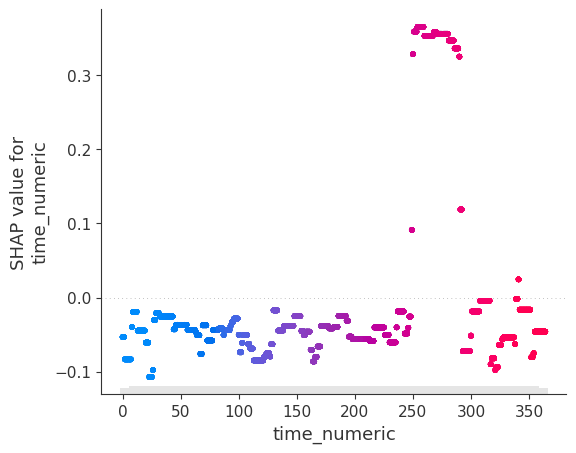

In [14]:
df['time_numeric'] = ((df.index - df.index.min())/pd.Timedelta(days=1)).astype(int)

# `apyxl` can be then used as:
target = 'b'
X, y = df.drop(columns=target), df[target]
model = XGBRegressorWrapper(random_state=0, max_evals=35).fit(X, y)
model.scatter(X, feature='a')
model.scatter(X, feature='time_numeric')

The fitted XGBoost regressor manages to capture the non-linear relationship between a and b (with the exception of extreme values) as well as the temporary, time-localized shift between the two time series. This trend, in other words the behavior of b that can't be explained by a, can be isolated:

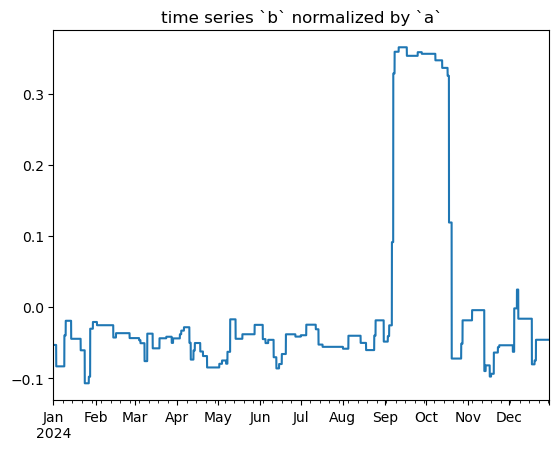

In [15]:
shap_values = model.compute_shap_values(X)
pd.Series(shap_values[:, 'time_numeric'].values, index=X.index).plot(title='time series `b` normalized by `a`')
plt.show()